In [1]:
import os
os.chdir("..")

In [2]:
from deepsvg.svglib.svg import SVG

from deepsvg import utils
from deepsvg.difflib.tensor import SVGTensor
from deepsvg.svglib.utils import to_gif, make_grid, make_grid_lines, make_grid_grid
from deepsvg.svglib.geom import Bbox
#from deepsvg.svgtensor_dataset import SVGTensorDataset, load_dataset
from deepsvg.svg_dataset import SVGDataset, load_dataset


from deepsvg.utils.utils import batchify, linear

import torch

# Font generation and interpolation

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [17]:
MODEL_PATH = "/home/sh/o/unsymbols/deepsvg/pretrained/hierarchical_ordered.pth.tar"
MODEL_PATH = "/home/sh/o/unsymbols/MODELS/rancher/complete/2025-08-10_full/best.pth.tar"
MODEL_PATH = "/home/sh/o/unsymbols/MODELS/rancher/complete/2025-08-10_skel/c_best.pth.tar"

Load the pretrained model 

In [18]:
pretrained_path = MODEL_PATH
from configs.unsymbols.env_ours_hier_ord import Config

cfg = Config()
model = cfg.make_model().to(device)
utils.load_model(pretrained_path, model, device=device)
model.eval();

In [19]:
model.cfg.pred_mode

'one_shot'

In [20]:
#dataset = load_dataset(cfg)

In [21]:
"""
def easein_easeout(t):
    return t*t / (2. * (t*t - t) + 1.);

def interpolate(z1, z2, label, n=25, filename=None, ease=True, do_display=True):
    alphas = torch.linspace(0., 1., n)
    if ease:
        alphas = easein_easeout(alphas)
    z_list = [(1-a) * z1 + a * z2 for a in alphas]
    
    img_list = [sample_unsymbol(z=z, do_display=False, return_png=True) for z in z_list]
    to_gif(img_list + img_list[::-1], file_path=filename, frame_duration=1/12)
"""

'\ndef easein_easeout(t):\n    return t*t / (2. * (t*t - t) + 1.);\n\ndef interpolate(z1, z2, label, n=25, filename=None, ease=True, do_display=True):\n    alphas = torch.linspace(0., 1., n)\n    if ease:\n        alphas = easein_easeout(alphas)\n    z_list = [(1-a) * z1 + a * z2 for a in alphas]\n    \n    img_list = [sample_unsymbol(z=z, do_display=False, return_png=True) for z in z_list]\n    to_gif(img_list + img_list[::-1], file_path=filename, frame_duration=1/12)\n'

In [9]:
def get_z(temperature=.3):
    z = torch.randn(1, 1, 1, cfg.model_cfg.dim_z).to(device) * temperature
    #z = torch.randn(1, 1, 1, cfg.model_cfg.dim_z) * temperature
    
    return z

In [22]:
def sample_unsymbol(z=None, temperature=.3, filename=None, do_display=True, return_svg=False, return_png=False, *args, **kwargs):
    label_id = 4 #ignored anyway
    
    if z is None:
        z = torch.randn(1, 1, 1, cfg.model_cfg.dim_z).to(device) * temperature
    
    label, = batchify((torch.tensor(label_id),), device=device)
    commands_y, args_y = model.greedy_sample(None, None, None, None, label=label, z=z)
    tensor_pred = SVGTensor.from_cmd_args(commands_y[0].cpu(), args_y[0].cpu())

    svg_path_sample = SVG.from_tensor(tensor_pred.data, viewbox=Bbox(256), allow_empty=True).normalize().split_paths()
    
    if return_svg:
        return svg_path_sample
    
    return svg_path_sample.draw(file_path=filename, do_display=do_display, return_png=return_png, *args, **kwargs)

In [11]:
def sample_all_unsymbols(filename=None, num_symbols = 10, temperatures=[0.0, 20], digits_in_row=10, verbose=False):
    rows = []
    cur_row = []
    for i in range(num_symbols):
        temp = temperatures[0]+((temperatures[1]-temperatures[0])/num_symbols)*i
        if verbose:
            print(temp)
        svg_digits = sample_unsymbol(return_svg=True, temperature=temp)
        cur_row.append(svg_digits)
        if len(cur_row)>digits_in_row:
            rows.append(cur_row.copy())
            cur_row=[]
   
    grid = make_grid_lines(rows)
    grid.draw(file_path=filename)

In [36]:
from pathlib import Path
def sample_to_directory(n_samples, output_dir, temperature=10.0, do_display=False):
    output_dir=Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    for i in range(n_samples):
        if i%10==0:
            print(f"{i}/{n_samples}")
        svg = sample_unsymbol(return_svg=True, temperature=temperature)
        svg_path = (output_dir / f"{i:002}_{temperature}.svg")
        svg.draw(file_path=svg_path, do_display=do_display)
    

## Generate unsymbols

In [37]:
sample_to_directory(20, "/tmp/sample", 15)

0/20
10/20


temperature=0.0


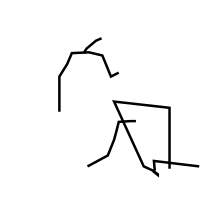

temperature=5.0


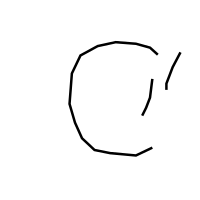

temperature=10.0


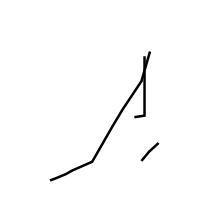

temperature=15.0


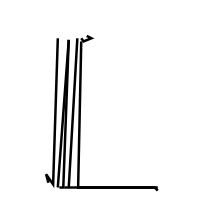

temperature=20.0


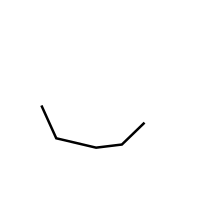

temperature=25.0


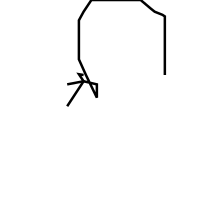

temperature=30.0


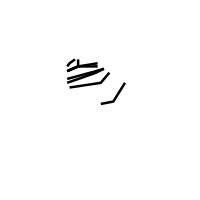

temperature=35.0


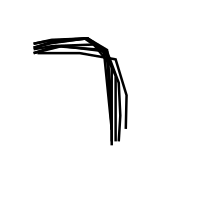

temperature=40.0


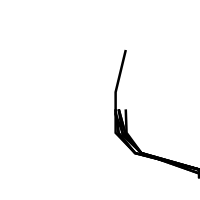

temperature=45.0


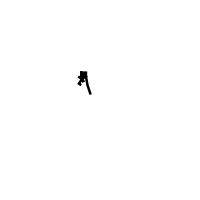

In [23]:
NUM_SAMPLES = 10
for i in range(NUM_SAMPLES):
    temperature=(50/NUM_SAMPLES)*i
    print(f"{temperature=}")
    sample_unsymbol(with_points=False, with_handles=False, with_moves=False, temperature=temperature)

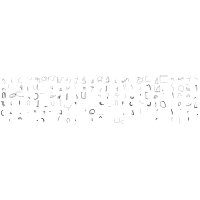

In [25]:
sample_all_unsymbols("/tmp/alluns.svg", num_symbols=150, temperatures=(5.0, 50.0), digits_in_row=24)